In [2]:
###################
##
## Preparation
##
###################

import pandas as pd
import numpy as np
import time
import sys
from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import plotly.plotly as py
import plotly.graph_objs as go

**data read from file**

In [3]:
order_df = pd.read_csv('__.csv')

In [4]:
order_df['date'] = pd.to_datetime(order_df['date'])
order_df = order_df.sort_values(by = ['date'])
order_df.index = order_df['date']
order_df.tail()

,date,order
date,,
2018-09-10,2018-09-10,156.83
2018-09-17,2018-09-17,173.49
2018-09-24,2018-09-24,146.20
2018-10-01,2018-10-01,136.76
2018-10-08,2018-10-08,154.80


In [5]:
data = [
    go.Scatter(
        x=order_df.index, # assign x as the dataframe column 'x'
        y=order_df.order
    )
]

py.iplot(data)

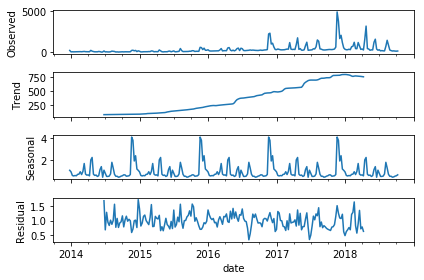

In [7]:
res = sm.tsa.seasonal_decompose(order_df['order'].interpolate(),
                                freq=52,
                                model='multiplicative')
resplot = res.plot()

In [8]:
res.resid[np.isfinite(res.resid) == False] = 0

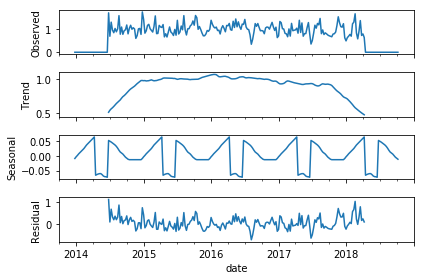

In [9]:
res_resid = sm.tsa.seasonal_decompose(res.resid.interpolate(),
                                freq=52,
                                model='additive ')
resplot = res_resid.plot()

### divide into train and test

In [11]:
mid = int(np.round(len(order_df)*0.8))
train = order_df.head(mid)
train_se = pd.Series(data = train['order'], index = train['date'] )
train_se = train_se.asfreq('W-Mon')

test = order_df[mid:]
test_se = pd.Series(data = test['order'], index = test['date'] )
test_se = test_se.asfreq('W-Mon')

print (train_se.tail(), test_se.head())

date
2017-09-25    302.13
2017-10-02    308.80
2017-10-09    341.74
2017-10-16    329.70
2017-10-23    326.16
Freq: W-MON, Name: order, dtype: float64 date
2017-10-30     350.50
2017-11-06     394.95
2017-11-13     629.63
2017-11-20    4880.21
2017-11-27    3758.51
Freq: W-MON, Name: order, dtype: float64


**ARIMA** 
stands for Auto-Regressive (AR) Integrated (I) Moving Average (MA). The ARIMA model is all about differencing the series to make it stationary. 

We do this by taking differences of the variable over time. We have three methods of “taking differences” available to us in an ARIMA model. The AR term, the I term, and the MA term. 

The $I$ term is a full difference. That is today’s value minus yesterday’s value. That’s it.

The $AR$ term is very much related. The way that I like to think of the AR term is that it is a partial difference. The coefficient on the AR term will tell you the percent of a difference you need to take. 

$MA$ term tells you what percent to add back into the error term after differencing. Greene’s book Econometric Analysis, makes the point that this is really about patching up the standard errors. At least that’s what I got out of his discussion of the topic.

### Choose the parameters

In [17]:
import itertools  

# define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
 
# generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

seasonal = 52
# generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], seasonal) for x in list(itertools.product(p, d, q))]

In [12]:
# compute the Akaike Information Criterion (AIC): choose the model with lowest AIC.
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
tmp_model = None
best_mdl = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            tmp_mdl = sm.tsa.statespace.SARIMAX(train_se,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False)
            
            res = tmp_mdl.fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_mdl = tmp_mdl
        
        except:
            print(param,param_seasonal, "Unexpected error:", sys.exc_info()[1])
            continue
            
            
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

(0, 0, 0) (0, 0, 0, 52) Unexpected error: Number of states in statespace model must be a positive number.


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 0, 0) (0, 1, 0, 52) Unexpected error: could not broadcast input array from shape (0,0) into shape (52,52)
(0, 0, 0) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(0, 0, 0) (1, 0, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(0, 0, 0) (1, 0, 1, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(0, 0, 0) (1, 1, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(0, 0, 0) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 0, 1) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(0, 0, 1) (1, 0, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(0, 0, 1) (1, 0, 1, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(0, 0, 1) (1, 1, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(0, 0, 1) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs
(0, 1, 0) (0, 0, 0, 52) Unexpected error: could not broadcast input array from shape (0,0) into shape (1,1)


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 1, 0) (0, 1, 0, 52) Unexpected error: could not broadcast input array from shape (0,0) into shape (53,53)
(0, 1, 0) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(0, 1, 0) (1, 0, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(0, 1, 0) (1, 0, 1, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(0, 1, 0) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(0, 1, 1) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(0, 1, 1) (1, 0, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(0, 1, 1) (1, 0, 1, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(0, 1, 1) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 0, 0) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(1, 0, 0) (1, 0, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(1, 0, 0) (1, 0, 1, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(1, 0, 0) (1, 1, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(1, 0, 0) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 0, 1) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(1, 0, 1) (1, 0, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(1, 0, 1) (1, 0, 1, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(1, 0, 1) (1, 1, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(1, 0, 1) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



(1, 1, 0) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(1, 1, 0) (1, 0, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(1, 1, 0) (1, 0, 1, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(1, 1, 0) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs
(1, 1, 1) (0, 0, 1, 52) Unexpected error: Singular matrix
(1, 1, 1) (0, 1, 1, 52) Unexpected error: maxlag should be < nobs
(1, 1, 1) (1, 0, 0, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(1, 1, 1) (1, 0, 1, 52) Unexpected error: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.
(1, 1, 1) (1, 1, 1, 52) Unexpected error: maxlag should be < nobs
Best SARIMAX(1, 1, 1)x(1, 1, 0, 52)12 model - AIC:3364.454702757849


In [12]:
# define SARIMAX model and fit it to the data
mdl = sm.tsa.statespace.SARIMAX(train_se,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 52),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
res = mdl.fit()

# print statistics
print(res.aic)
print(res.summary())

2014.5510423594355
                                 Statespace Model Results                                 
Dep. Variable:                              order   No. Observations:                  200
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 52)   Log Likelihood               -1003.276
Date:                            Thu, 18 Oct 2018   AIC                           2014.551
Time:                                    16:22:15   BIC                           2027.744
Sample:                                12-30-2013   HQIC                          2019.890
                                     - 10-23-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5367      0.059      9.074      0.000       0.421       0.653
ma.L1         -0

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower than 0.01, so it is reasonable to retain all of them in our model.
The Ljung-Box Q statistic is used to test the $H_0$ that the complete data set is independently distributed, i.e. not serially correlated. The null is rejected if
$$
 \chi^2_{1-\alpha}(\nu)
$$
where the DoF (Degree of Freedom) $\nu = n - k$. Computing the critical value of the Chi-square distribution one finds that the resulting model exhibits serially uncorrelated errors:

In [17]:
from scipy.stats import chi2
chi = chi2.isf(q=0.05, df=192-3)
chi

222.07564642657547

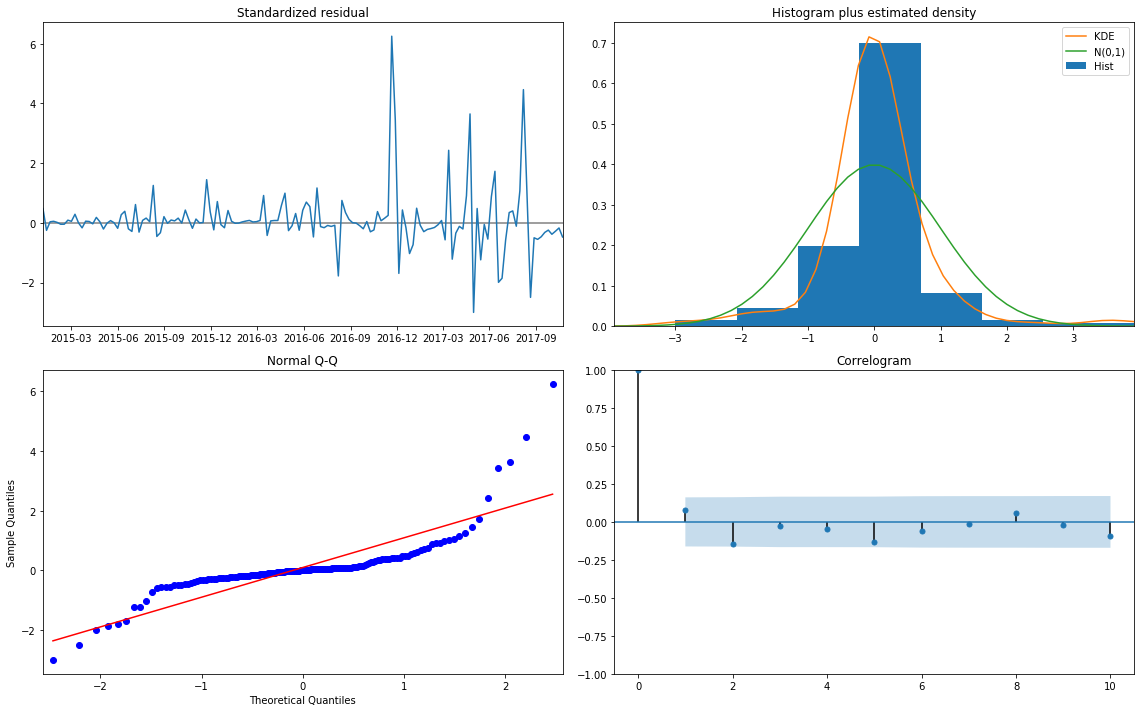

In [13]:
res.plot_diagnostics(figsize=(16, 10))
plt.tight_layout()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

predx = res.predict(start=mid, end=mid+len(test_se)-1) #exog=pd.DataFrame(hol.holiday_flg[450:])
print(res.summary())

def plotSARIMAX(train_data, test_data, pred):
    fig = plt.figure(figsize=(12, 8))
    layout = (2, 2)
    ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax3 = plt.subplot2grid(layout, (1, 0))
    ax4 = plt.subplot2grid(layout, (1, 1))
    train_data.plot(ax=ax1);
    t = 'MSE: {}'.format(mean_squared_log_error(test_data,pred))
    pred.plot(ax=ax1, title=t, label = 'Prediction')
    test_data.plot(ax=ax1, label = 'Reality')
    ax3 = sm.graphics.tsa.plot_acf(res.resid, lags=seasonal, alpha=.05, ax=ax3, title="ACF of residuals")
    ax4 = sm.graphics.tsa.plot_pacf(res.resid, lags=seasonal, alpha=.05, ax=ax4, title="PACF of residuals")
    plt.tight_layout()
    ax1.legend()
    print("ACF and PACF of residuals")
    
plotSARIMAX(train_se, test_se, predx)

### Prediction

In [15]:
pred2 = res.get_prediction(start=mid, end=mid+len(test_se)-1)
print(res.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              order   No. Observations:                  200
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 52)   Log Likelihood               -1003.276
Date:                            Thu, 18 Oct 2018   AIC                           2014.551
Time:                                    16:22:44   BIC                           2027.744
Sample:                                12-30-2013   HQIC                          2019.890
                                     - 10-23-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5367      0.059      9.074      0.000       0.421       0.653
ma.L1         -0.9724      0.030   

ACF and PACF of residuals


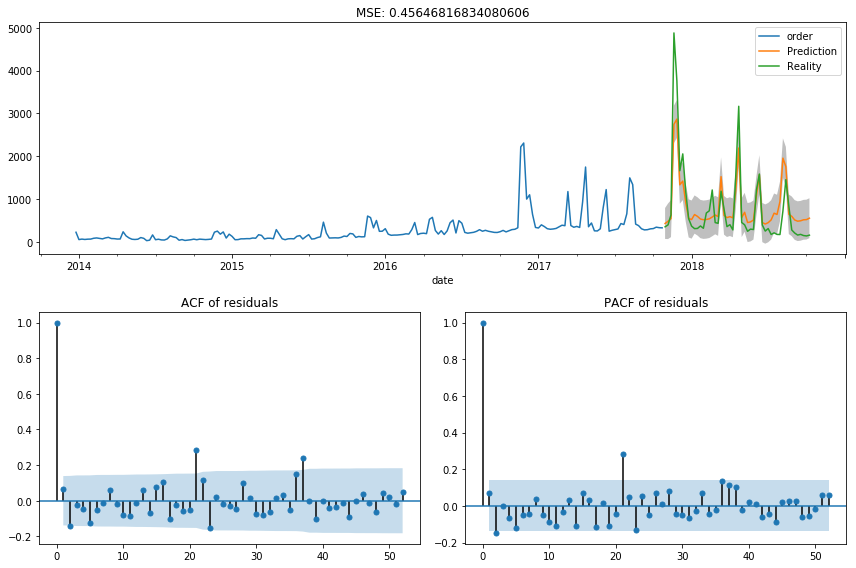

In [18]:
def plotSARIMAX_m(train_data, test_data, pred_model):
    fig = plt.figure(figsize=(12, 8))
    layout = (2, 2)
    ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)
    ax3 = plt.subplot2grid(layout, (1, 0))
    ax4 = plt.subplot2grid(layout, (1, 1))
    train_data.plot(ax=ax1);
    t = 'MSE: {}'.format(mean_squared_log_error(test_data,pred_model.predicted_mean))
    pred_model.predicted_mean.plot(ax=ax1, title=t, label = 'Prediction')
    test_data.plot(ax=ax1, label = 'Reality')
    ax1.fill_between(pred_model.conf_int(alpha = 0.1).index, 
                     pred_model.conf_int(alpha = 0.1).iloc[:,0], 
                     pred_model.conf_int(alpha = 0.1).iloc[:,1], 
                     alpha=0.5,facecolor='grey')
    ax3 = sm.graphics.tsa.plot_acf(res.resid, lags=seasonal, alpha=.05, ax=ax3, title="ACF of residuals")
    ax4 = sm.graphics.tsa.plot_pacf(res.resid, lags=seasonal, alpha=.05, ax=ax4, title="PACF of residuals")
    plt.tight_layout()
    ax1.legend()
    print("ACF and PACF of residuals")
    
plotSARIMAX_m(train_se, test_se, pred2)


### Choose appropriate Alpha for accepted range

In [19]:
def accuracy(test_data, model, alpha=0.05):
    a = 0
    anomly = list()
    for i in range(len(test_data)):
        if (test_data[i] >=  model.conf_int(alpha = alpha).iloc[i,0] 
            and test_data[i] <=  model.conf_int(alpha = alpha).iloc[i,1]): 
            a += 1
        else: anomly.append([str(test_data.index[i]), test_data[i]])
  
    return round(a/len(test_data),4), anomly
    
def compare_acc(test_data, model, range_start, range_end, range_sep):
    alpha = np.arange(range_start,range_end, range_sep)
    acc = pd.DataFrame(columns = ['alpha','acc','no_of_ab'])
    acc["alpha"] = alpha
    for i in range(len(alpha)):
        acc.iloc[i,1] = accuracy(test_data, model, alpha=alpha[i])[0]
        acc.iloc[i,2] = len(accuracy(test_data, model, alpha=alpha[i])[1])
        
    data = [
        go.Scatter(
            x=acc.alpha, # assign x as the dataframe column 'x'
            y=acc.acc,
            name ='Accuracy'
        ),
        go.Scatter(
            x=acc.alpha,
            y=acc.no_of_ab,
            name = 'The number of abnomal date',
            yaxis='y2'
        )
    ]
    
    layout = go.Layout(
    title='Accuracy comparison based on different Alpha',
    yaxis=dict(
        title='Accuracy'
    ),
    yaxis2=dict(
        title='Abnormal Date',
        titlefont=dict(
            color='rgb(148, 103, 189)'
        ),
        tickfont=dict(
            color='rgb(148, 103, 189)'
        ),
        overlaying='y',
        side='right'
    )
)
    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig)

compare_acc(test_se, pred2,0.01,0.2,0.01)

![title](img/newplot.png)

In [20]:
def hightlight(alpha, test_data = test_se, model = pred2):
    anomly_date = accuracy(test_data, model, alpha=alpha)[1]
    anomly = pd.DataFrame(columns = ['alpha','anomly_date','anomly_y'])
    anomly['org'] = anomly_date[:]
    for i in range(len(anomly_date)):
        anomly.iloc[i,0] = alpha
        anomly.iloc[i,1] = anomly.iloc[i,3][0]
        anomly.iloc[i,2] = anomly.iloc[i,3][1]
    return anomly

import random
def random_color():
    r = random.randint(50,255)
    g = random.randint(50,255)
    b = random.randint(50,255)
    return (r,g,b)

def areaplot(alpha):
    color = random_color()
    trace0 = go.Scatter(
        x=pred2.conf_int(alpha=alpha).index,
        y=pred2.conf_int(alpha=alpha).iloc[:,1],
        fill= None,
        mode='lines',
        showlegend=False,
        name='Upper Bound',
        line=dict(width=0.5,
                  color='rgba({},{},{},{})'.format(color[0],color[1],color[2],0.5)
        ))
    trace1 = go.Scatter(
        x=pred2.conf_int(alpha=alpha).index,
        y= pred2.conf_int(alpha=alpha).iloc[:,0],
        fill='tonexty',
        mode='lines',
        line=dict(width=0.5,
                  color='rgba({},{},{},{})'.format(color[0],color[1],color[2],0.5)),
        name = 'alpha = {}'.format(alpha)
        )
    trace2 = go.Scatter(
        x=test_se.index, # assign x as the dataframe column 'x'
        y=test_se,
        name = 'Real data',
        line=dict(color='rgb{}'.format(color)),
        mode='lines')

    trace3 = go.Scatter(
        x = hightlight(alpha).anomly_date,
        y = hightlight(alpha).anomly_y,
        name = 'Alert points',
        hoverinfo='none',
        mode = 'markers'
    )
    data = [trace0, trace1, trace2, trace3]
    return py.iplot(data)
##rgb(255,253,180),'rgb(255,216,55)'

In [24]:
areaplot(0.01)

![title](img/newplot-2.png)

In [22]:
areaplot(0.05)

![title](img/newplot-3.png)

In [23]:
areaplot(0.13)

![title](img/newplot-4.png)